<a href="https://colab.research.google.com/github/yaqianhe/GIA/blob/main/Lecture12_StatisticAnalysis_I%26II%26III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Lecture 12: Statistical Analysis: SciPy I&II&III
##Yaqian He
##Department of Geography
##University of Central Arkansas


Statistical analysis is very useful for identifying data characters. In this section, you will learn how to use Python to explore:

(1) Data normality

(2) Autocorrelation

(3) t-test for mean difference

(4) Trend analysis

(5) Correlation



In [ ]:
# Import necessary packages 
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import xarray as xr
import netCDF4 as nc
from statsmodels.formula.api import ols
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Dealing with error thrown by one of the plots
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')


# Adjust font size and style of all plots in notebook with seaborn
sns.set(font_scale=1.5, style="whitegrid")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data used in this section is obtained from https://www.ncdc.noaa.gov/cdo-web/search

In [ ]:
# read the data
# as I built the script in Colab, I need to mount my google drive
# You do not need to do this step, as you use the Anaconda Jupyter Notebook
from google.colab import drive
drive.mount('/content/drive/')

# !!!Change the path for your data
file_path='/content/drive/My Drive/Colab Notebooks/GIA_2021Spring/AR_TempPrecip.csv'

ar_temp_precip_1980_2019 = pd.read_csv(file_path,
                                  # Make sure the dates import in datetime format
                                  parse_dates=['DATE'],
                                  # Set DATE as the index so you can subset data by time period
                                  index_col=['DATE'],
                                  # Mask no data values so they are not plotted / used in analysis
                                  na_values=['999.99'])

Mounted at /content/drive/


## 1. Plot and View Data Characters

In [ ]:
# roughly check data
ar_temp_precip_1980_2019.dtypes

STATION             object
NAME                object
LATITUDE           float64
LONGITUDE          float64
ELEVATION          float64
PRCP               float64
PRCP_ATTRIBUTES     object
TAVG               float64
TAVG_ATTRIBUTES     object
TMAX                 int64
TMAX_ATTRIBUTES     object
TMIN                 int64
TMIN_ATTRIBUTES     object
dtype: object

In [ ]:
ar_temp_precip_1980_2019.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,PRCP,PRCP_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
DATE,,,,,,,,,,,,,
1980-01-01,USW00003952,"NORTH LITTLE ROCK AIRPORT, AR US",34.8353,-92.2596,171.6,0.00,",,0,2400",NaN,NaN,56,",,0",33,",,0"
1980-01-02,USW00003952,"NORTH LITTLE ROCK AIRPORT, AR US",34.8353,-92.2596,171.6,0.00,",,0,2400",NaN,NaN,58,",,0",38,",,0"
1980-01-03,USW00003952,"NORTH LITTLE ROCK AIRPORT, AR US",34.8353,-92.2596,171.6,0.16,",,0,2400",NaN,NaN,47,",,0",31,",,0"
1980-01-04,USW00003952,"NORTH LITTLE ROCK AIRPORT, AR US",34.8353,-92.2596,171.6,0.00,",,0,2400",NaN,NaN,41,",,0",28,",,0"
1980-01-05,USW00003952,"NORTH LITTLE ROCK AIRPORT, AR US",34.8353,-92.2596,171.6,0.00,",,0,2400",NaN,NaN,51,",,0",29,",,0"


## 2. Extract Summer Data

To conduct statistical analysis, sometimes you need to explore data at inter-annual or intra-annual scales. In this section, you will learn how to get data for different seasons.


In [ ]:
# resample daily data to seasonal
ar_temp_precip_1980_2019_QS=ar_temp_precip_1980_2019.resample("QS-Dec").mean()
ar_temp_precip_1980_2019_QS.head()

,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,
1979-12-01,34.8353,-92.2596,171.6,0.068333,NaN,48.900000,30.950000
1980-03-01,34.8353,-92.2596,171.6,0.212826,NaN,69.641304,49.641304
1980-06-01,34.8353,-92.2596,171.6,0.014674,NaN,96.250000,73.217391
1980-09-01,34.8353,-92.2596,171.6,0.136813,NaN,73.846154,53.263736
1980-12-01,34.8353,-92.2596,171.6,0.090111,NaN,52.133333,33.022222


In [ ]:
# Extract JJA time series
ar_temp_precip_1980_2019_JJA =ar_temp_precip_1980_2019_QS[ar_temp_precip_1980_2019_QS.index.month ==6]
ar_temp_precip_1980_2019_JJA.head()

,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,,
1980-06-01,34.8353,-92.2596,171.6,0.014674,NaN,96.250000,73.217391
1981-06-01,34.8353,-92.2596,171.6,0.105870,NaN,90.282609,71.293478
1982-06-01,34.8353,-92.2596,171.6,0.171196,NaN,88.532609,69.456522
1983-06-01,34.8353,-92.2596,171.6,0.058478,NaN,91.358696,70.630435
1984-06-01,34.8353,-92.2596,171.6,0.061957,NaN,89.706522,69.630435


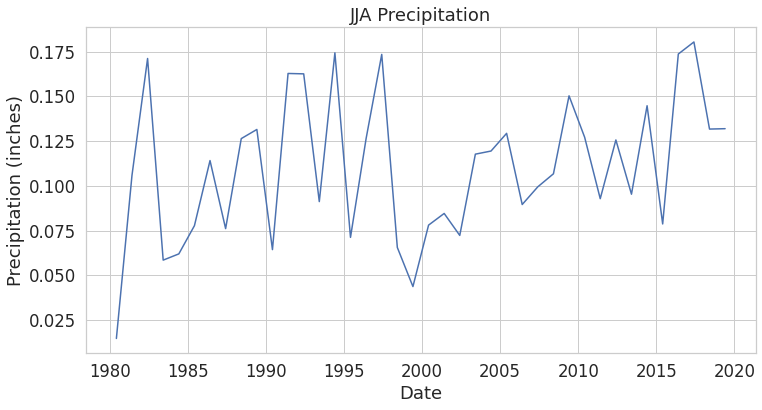

In [ ]:
# Plot precipitation during JJA
Precip=ar_temp_precip_1980_2019_JJA["PRCP"]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Precip)

ax.set(xlabel="Date",
       ylabel="Precipitation (inches)",
       title="JJA Precipitation")
plt.show()


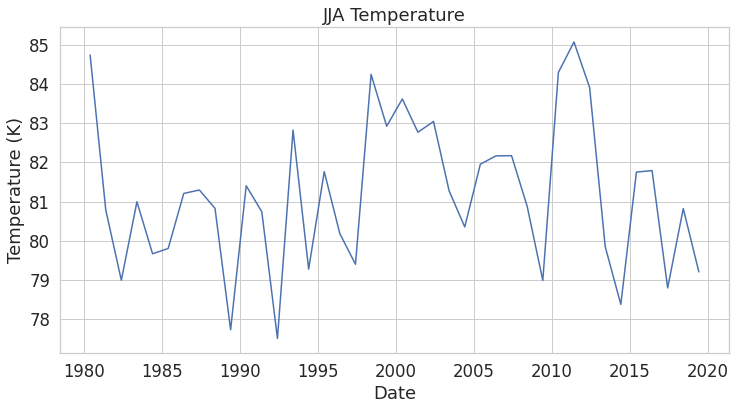

In [ ]:
# Plot Average Temperature during JJA
Tavg= (ar_temp_precip_1980_2019_JJA["TMAX"]+ar_temp_precip_1980_2019_JJA["TMIN"])/2

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Tavg)

ax.set(xlabel="Date",
       ylabel="Temperature (K)",
       title="JJA Temperature")
plt.show()

## 3. Statistical Analsysis

<h3>3.1 Checking Data Normality</h3>
Normality is an important prerequisite for many statistical anlayses. In this section, you will learn visual-based measurement for normality:

- Histogram and PDF
- QQ plot

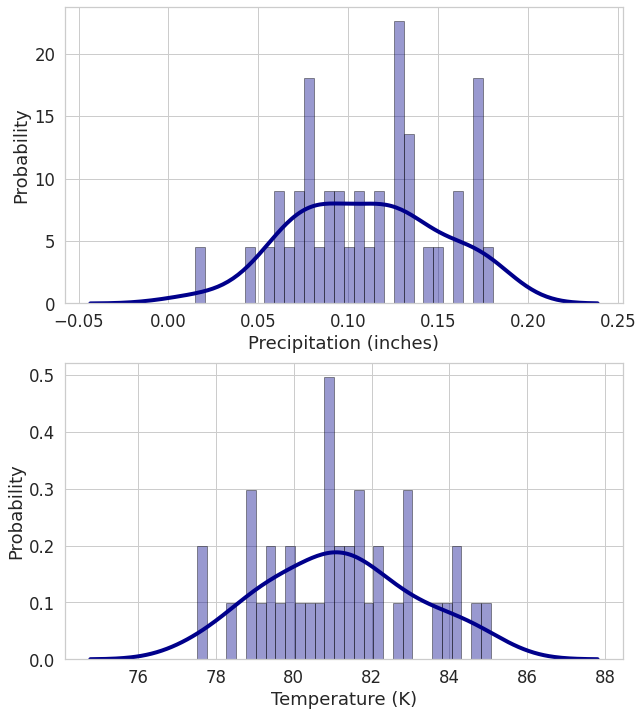

In [ ]:
# Check the normality of precipitation and temperature
# Plot histogram and PDF

fig = plt.figure(figsize=(10, 12))
ax1=plt.subplot(2,1,1)
ax1=sns.distplot(Precip, hist=True, kde=True, 
             bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

ax1.set(xlabel='Precipitation (inches)', ylabel='Probability')
#ax1.legend()

ax2=plt.subplot(2,1,2)
ax2=sns.distplot(Tavg, hist=True, kde=True, 
             bins=int(30), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set(xlabel='Temperature (K)', ylabel='Probability')
#ax2.legend()

plt.show()

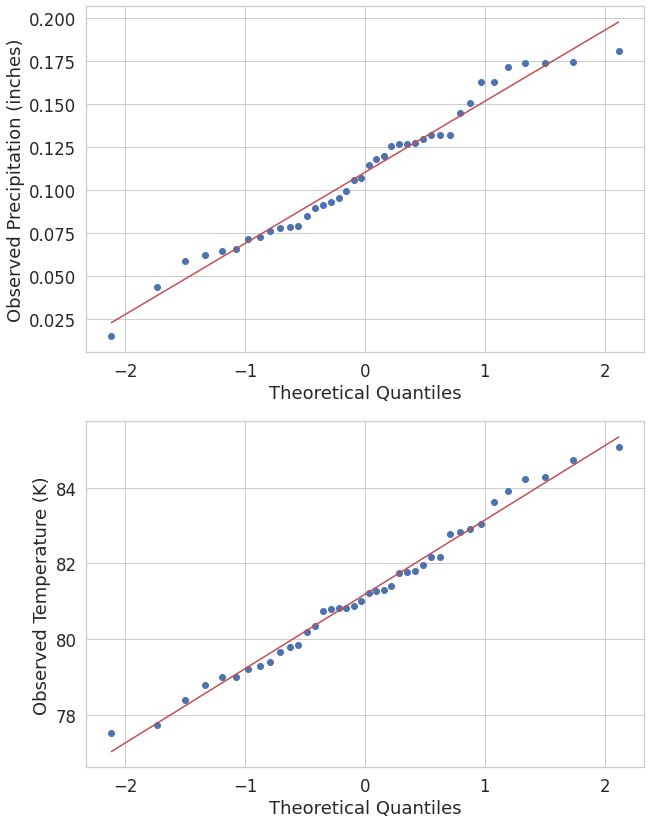

In [ ]:
# Plot QQ plot
fig = plt.figure(figsize=(10, 14))

ax1=plt.subplot(2,1,1)
res  = stats.probplot(Precip, plot=plt)
ax1.set_title("")
ax1.set_xlabel("Theoretical Quantiles")
ax1.set_ylabel("Observed Precipitation (inches)")
#ax1.legend()

ax2=plt.subplot(2,1,2)
res  = stats.probplot(Tavg, plot=plt)
ax2.set_title("")
ax2.set_xlabel("Theoretical Quantiles")
ax2.set_ylabel("Observed Temperature (K)")
#ax2.legend()

plt.show()



<h3>3.2 Checking Data Autocorrelation</h3>

Time series data may has temporal autocorrelation, which violate the independence of data required by Statistics. In this section, you will learn how to check the autocorrelation.

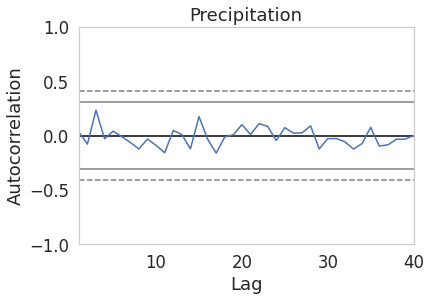

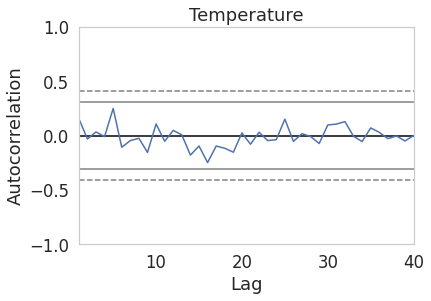

In [ ]:
# Check Autocorrelation
plt.figure()
ax1=pd.plotting.autocorrelation_plot(Precip) 
ax1.set_title("Precipitation")
#ax1.legend()

plt.figure()
ax2=pd.plotting.autocorrelation_plot(Tavg) 
ax2.set_title("Temperature") 
#ax2.legend()

plt.show()


The horizontal lines in the plot correspond to 95% and 99% confidence level.

<h3>3.3 t-test</h3>

To explore whether the mean values from different groups are same or not, you can use two-sample t-test. In this section, you will explore if the mean JJA temperatures from 1980-1985 and 2014-2019 are same?  



In [ ]:
#Extract JJA temperature from 1980-1985 and 2014-2019, respectively
Tavg_8085=Tavg['1980-06-01':'1985-06-01']
Tavg_8085

DATE
1980-06-01    84.733696
1981-06-01    80.788043
1982-06-01    78.994565
1983-06-01    80.994565
1984-06-01    79.668478
1985-06-01    79.804348
Freq: 4QS-DEC, dtype: float64

In [ ]:
Tavg_1419=Tavg['2014-06-01':'2019-06-01']
Tavg_1419

DATE
2014-06-01    78.380435
2015-06-01    81.750000
2016-06-01    81.788043
2017-06-01    78.798913
2018-06-01    80.820652
2019-06-01    79.206522
Freq: 4QS-DEC, dtype: float64

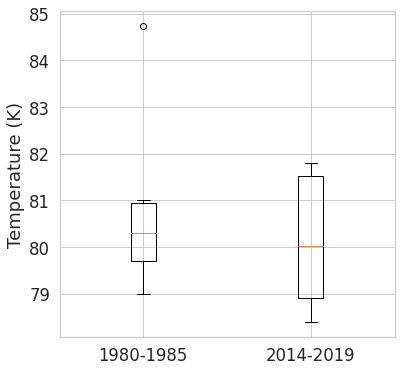

P value is 0.5131302964893463


In [ ]:
# Plot data statistical summaries using boxplot
data=[Tavg_8085,Tavg_1419]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.boxplot(data)
ax.set_xticklabels(['1980-1985', '2014-2019'])
ax.set_ylabel('Temperature (K)')  
plt.show()

# t-test 
tstatistic, Pvalue= stats.ttest_ind(Tavg_8085, Tavg_1419)   
print('P value is',Pvalue)



If the P less then 0.1, indicating the difference is signifincatly at 10% level.

<h3>3.3 Trend Analysis</h3>

Now you will learn how to use statistical analysis to determine how temperature change over time.


In [ ]:
#define year
year=np.arange(1980,2019.1,1)
year

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016., 2017., 2018., 2019.])

In [ ]:
data = pd.DataFrame({'x': year, 'y': Tavg})
model = ols("y ~ x", data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.2772
Date:                Thu, 07 Apr 2022   Prob (F-statistic):              0.602
Time:                        19:50:39   Log-Likelihood:                -82.073
No. Observations:                  40   AIC:                             168.1
Df Residuals:                      38   BIC:                             171.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.3260     52.913      1.008      0.3

In [ ]:
# calculate the trend line
z1 = [model.params[1],model.params[0]]
p1 = np.poly1d(z1)
p1

poly1d([1.39321111e-02, 5.33260319e+01])

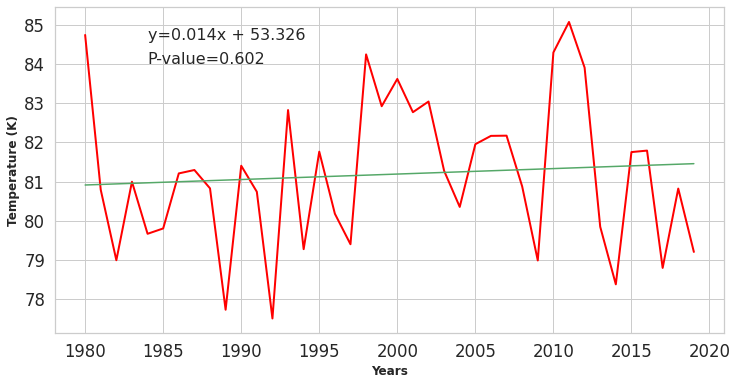

In [ ]:
# Plot the trend line
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(year, Tavg, lw=2, color='red') 
ax1.set_xlabel('Years',fontsize=12,fontweight='bold')
ax1.set_ylabel('Temperature (K)',fontsize=12,fontweight='bold')
#add trend line
ax1.plot(year,p1(year),"g-")
#add the trend equation:
ax1.text(1984,84.6, "y=%.3fx + %.3f"%(z1[0],z1[1]), fontsize=16)
ax1.text(1984,84, "P-value=%.3f"% model.pvalues[1], fontsize=16)
plt.show()


<h3>3.3 Correlation Analysis</h3>

You can also use correlation analysis to investigate the relationship between two variables. In this section, you will learn how to use Pearson's correlation to explore the association between JJA temperature and JJA precipitation.


In [ ]:
rvals, pvals= stats.pearsonr(Precip,Tavg)
print("R value is:",rvals,"P avlue is:", pvals)

R value is: -0.5803648986574624 P avlue is: 8.652207865230602e-05


##4. Statistic analysis for raster data
In the previous sections, you learned how to conduct statistical analysis for two time-series datasets. In this section, you will learn how to apply the knowlege to time-series raster data.

You will use the data from ERA5, a commonly used climate data in NetCDF format:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=form

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# !!!Change the path for your data
file_path='/content/drive/My Drive/Colab Notebooks/GIA_2022Spring/RunoffET.nc'
ds = xr.open_dataset(file_path)
ds

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 101, time: 252)
Coordinates:
  * longitude  (longitude) float32 85.0 85.1 85.2 85.3 ... 94.7 94.8 94.9 95.0
  * latitude   (latitude) float32 40.0 39.9 39.8 39.7 ... 30.3 30.2 30.1 30.0
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
Data variables:
    ro         (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-27 23:37:37 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [ ]:
#check time dimension
ds.time

<xarray.DataArray 'time' (time: 252)>
array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2020-12-01
Attributes:
    long_name:  time

In [ ]:
#Convert monthly data to seasonal
ds_qs=ds.resample(time="QS-Dec").mean()
ds_qs

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 101, time: 85)
Coordinates:
  * time       (time) datetime64[ns] 1999-12-01 2000-03-01 ... 2020-12-01
  * longitude  (longitude) float32 85.0 85.1 85.2 85.3 ... 94.7 94.8 94.9 95.0
  * latitude   (latitude) float32 40.0 39.9 39.8 39.7 ... 30.3 30.2 30.1 30.0
Data variables:
    ro         (time, latitude, longitude) float32 0.0 0.0 ... 0.001362 0.001463
    e          (time, latitude, longitude) float32 -1.831e-05 ... -4.245e-05

In [ ]:
ds_qs.time.dt.month

<xarray.DataArray 'month' (time: 85)>
array([12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,
        3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,
        6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,
        9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9,
       12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12,  3,  6,  9, 12])
Coordinates:
  * time     (time) datetime64[ns] 1999-12-01 2000-03-01 ... 2020-12-01

In [ ]:
#Extract JJA data
ds_JJA=ds_qs.sel(time=(ds_qs.time.dt.month == 6))
ds_JJA

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 101, time: 21)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-01 2001-06-01 ... 2020-06-01
  * longitude  (longitude) float32 85.0 85.1 85.2 85.3 ... 94.7 94.8 94.9 95.0
  * latitude   (latitude) float32 40.0 39.9 39.8 39.7 ... 30.3 30.2 30.1 30.0
Data variables:
    ro         (time, latitude, longitude) float32 1.569e-06 ... 0.01313
    e          (time, latitude, longitude) float32 -0.0003672 ... -0.00193

In [ ]:
#Trend and correlation analysis for each grid cell
Runoff=ds_JJA['ro']
ET=ds_JJA['e']
Time=ds_JJA['time']
lat=ds_JJA['latitude']
lon=ds_JJA['longitude']
slopvals_array=np.zeros((lat.size, lon.size))
rvals_array=np.zeros((lat.size, lon.size))
pvals_array_slop=np.zeros((lat.size, lon.size))
pvals_array_r=np.zeros((lat.size, lon.size))
years=np.arange(2000,2021,1)

In [ ]:
#Treand anlysis
for j in range(lat.size):
  for k in range(lon.size):
    slopvals_array[j,k], intercept, r_value, pvals_array_slop[j,k], se = stats.linregress(years,Runoff[:,j,k].values)

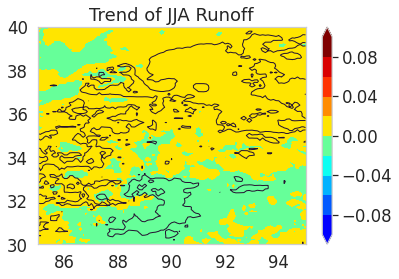

In [ ]:
#plot trend map
#Creating a map for one time step
levs = np.arange(-0.1, 0.11, 0.02)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
plt.contourf(lon, lat, slopvals_array[:,:], levs,cmap=cm,extend="both")
#plot the color scale
plt.colorbar()
#example of how to add a contour line
plt.contour(lon, lat, pvals_array_slop[:,:],levels=[0,0.1,1],linewidths=1)
#plot title
plt.title("Trend of JJA Runoff")
plt.show()

In [ ]:
#Correlation analysis
for j in range(lat.size):
  for k in range(lon.size):
    rvals_array[j,k],pvals_array_r[j,k]=stats.pearsonr(Runoff[:,j,k].values,ET[:,j,k].values)

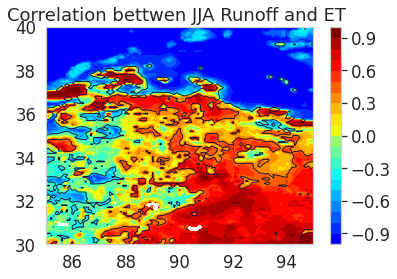

In [ ]:
#plot correlation map
#Creating a map for one time step
levs = np.arange(-1, 1.1, 0.1)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
plt.contourf(lon, lat, rvals_array[:,:], levs,cmap=cm)
#plot the color scale
plt.colorbar()
#example of how to add a contour line
plt.contour(lon, lat, pvals_array_r[:,:],levels=[0,0.1,1],linewidths=1)
#plot title
plt.title("Correlation bettwen JJA Runoff and ET ")
plt.show()

Reference: https://docs.xarray.dev/en/stable/user-guide/time-series.html